# Predicting Song Genres

## Initial attempt
* Try to predict the genres using only the numerical features

In [20]:
import pandas as pd
pd.options.display.max_columns = 200

songs = pd.read_csv('data/spotify_data.csv', index_col=[0])
songs.head()

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


### Before cleaning the data

In [21]:
songs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 114000 entries, 0 to 113999
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   track_id          114000 non-null  object 
 1   artists           113999 non-null  object 
 2   album_name        113999 non-null  object 
 3   track_name        113999 non-null  object 
 4   popularity        114000 non-null  int64  
 5   duration_ms       114000 non-null  int64  
 6   explicit          114000 non-null  bool   
 7   danceability      114000 non-null  float64
 8   energy            114000 non-null  float64
 9   key               114000 non-null  int64  
 10  loudness          114000 non-null  float64
 11  mode              114000 non-null  int64  
 12  speechiness       114000 non-null  float64
 13  acousticness      114000 non-null  float64
 14  instrumentalness  114000 non-null  float64
 15  liveness          114000 non-null  float64
 16  valence           114000 

### After cleaning the data

In [22]:
songs = songs.drop_duplicates(['track_name','artists'])
# Drop rows with missing values
songs.dropna(inplace=True)
songs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 81343 entries, 0 to 113999
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          81343 non-null  object 
 1   artists           81343 non-null  object 
 2   album_name        81343 non-null  object 
 3   track_name        81343 non-null  object 
 4   popularity        81343 non-null  int64  
 5   duration_ms       81343 non-null  int64  
 6   explicit          81343 non-null  bool   
 7   danceability      81343 non-null  float64
 8   energy            81343 non-null  float64
 9   key               81343 non-null  int64  
 10  loudness          81343 non-null  float64
 11  mode              81343 non-null  int64  
 12  speechiness       81343 non-null  float64
 13  acousticness      81343 non-null  float64
 14  instrumentalness  81343 non-null  float64
 15  liveness          81343 non-null  float64
 16  valence           81343 non-null  float64
 1

### Fit model

In [23]:
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

songs_data = songs.drop(columns = ["track_id", "artists", "album_name", "track_name", "track_genre"])
genres = songs["track_genre"]
# Numerically encode the labels
label_encoder = LabelEncoder()
encoded_genres = label_encoder.fit_transform(genres)
# Using stratify might help because we have an imbalanced dataset
X_train, X_test, y_train, y_test = train_test_split(songs_data, encoded_genres, test_size=0.3, 
                                                    stratify=encoded_genres, shuffle=True, random_state=100)
# Train model
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)

DecisionTreeClassifier()

### Evaluate performance

In [24]:
# Evaluate model
predictions = decision_tree.predict(X_test)
base_accuracy = accuracy_score(y_test, predictions)
base_f1_weighted = f1_score(y_test, predictions, average='weighted')
print("Baseline performance using a Decision Tree")
print(f"Accuracy: {base_accuracy}")
print(f"F1-score: {base_f1_weighted}")

Baseline performance using a Decision Tree
Accuracy: 0.24595336638937834
F1-score: 0.24672164897854254


In [26]:
def generate_predicitons_df(y_test, predictions, class_names):
    # Get more detailed performance information for each class
    f1 = f1_score(y_test, predictions, average=None)
    class_to_f1 = dict(zip(class_names, f1))
    # Sort f1-score in descending order
    class_to_f1 = dict(sorted(class_to_f1.items(), key=lambda item: item[1], reverse=True))
    grouped_by_genre = songs.groupby(['track_genre']).size()
    genre_count = grouped_by_genre.sort_values(ascending=False)
    count = list()
    for genre in class_to_f1.keys():
        count.append(genre_count[genre])
    predictions_df = pd.DataFrame([], columns=['genre', 'f1-score', 'count'])
    predictions_df['genre'] = class_to_f1.keys()
    predictions_df['f1-score'] = class_to_f1.values()
    predictions_df['count'] = count
    return predictions_df

predictions_df = generate_predicitons_df(y_test, predictions, label_encoder.classes_)
display(predictions_df)

,genre,f1-score,count
0,comedy,0.797178,987
1,grindcore,0.776014,965
2,sleep,0.750000,945
3,honky-tonk,0.594714,826
4,study,0.581197,996
...,...,...,...
108,rock,0.020619,167
109,house,0.000000,134
110,indie,0.000000,107
111,punk,0.000000,208


Worse performing classes seem to be the ones with lower number of samples

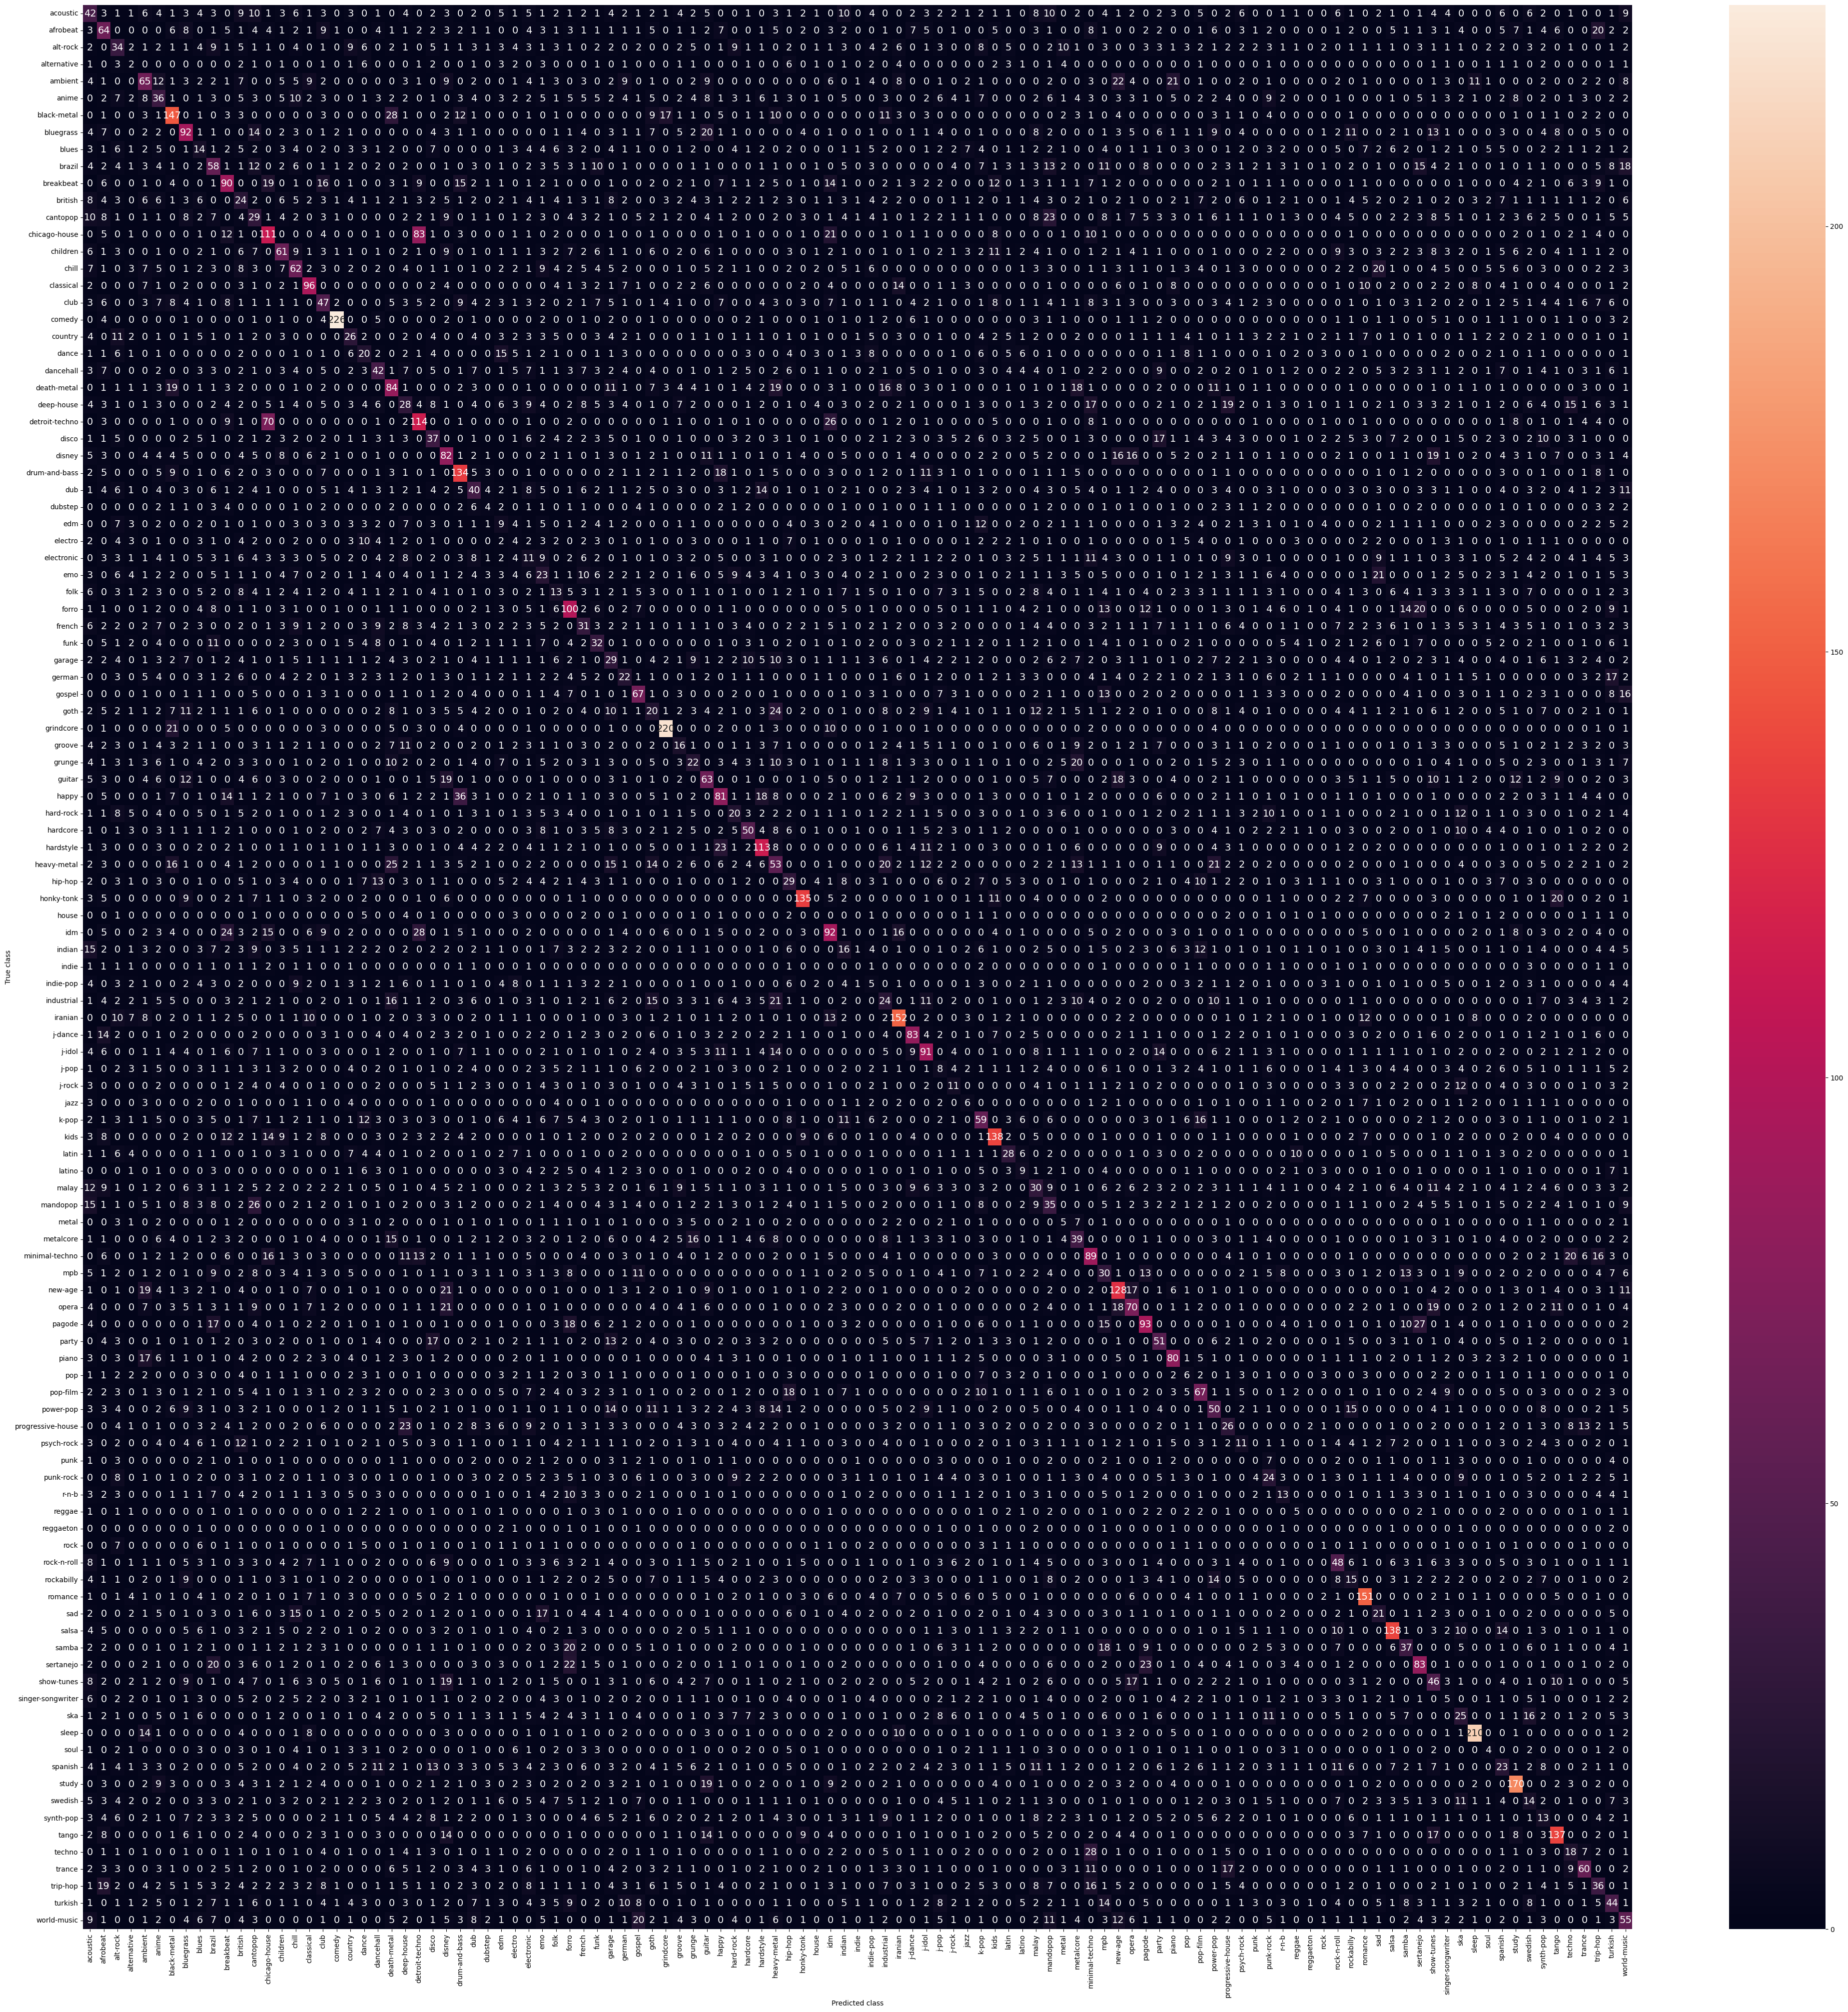

In [28]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(conf_matrix, class_names):
    cm_df = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)
    heatmap = sns.heatmap(cm_df, annot=True, fmt='d', annot_kws={"size": 14})
    heatmap.set(xlabel='Predicted class', ylabel='True class')
    return heatmap

cm = confusion_matrix(y_test, predictions)
heatmap = plot_confusion_matrix(cm, label_encoder.classes_)
plt.rcParams['figure.figsize'] = [50, 50]
plt.show()

Confusion matrix is huge and hard to read because there's more than 100 genres we are trying to predict

Some insights from the confusion matrix:
- The model predicted _ambient_ several times when the real class was _piano_
- There were alot of mixups between the electronic music genres
    - The model predicted often _deep house_ when the true classes were _synth pop_ and _progressive house_
    - Model predicted ~50 times _chicago house_ when the song was actually _detroit techno_
        - Almost the same scenario vice-versa: ~40 predictions for _detroit techno_ when song was _chicago house_
    - Same case for _techno_ and _minimal techno_
- It's probably a good idea to simplify our classification problem by combining some genres together
    - Example: combine _house_, _deep house_, and _chicago house_ under _house_

## Incorporating features from string attributes

In [29]:
string_features = songs[['artists', 'album_name', 'track_name']]
string_features.head()

,artists,album_name,track_name
0,Gen Hoshino,Comedy,Comedy
1,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic
2,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again
3,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love
4,Chord Overstreet,Hold On,Hold On


In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer

concatenated_features = (songs['artists'] + ' ' + songs['album_name'] + ' ' + songs['track_name']).to_list()
vectorizer = TfidfVectorizer()
count_matrix = vectorizer.fit_transform(concatenated_features)
print(f"Number of new features: {count_matrix.shape[1]}")

Number of new features: 77866


### Reduce number of features

In [31]:
# Use stemming and remove stopwords
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')
import re

stemmer = PorterStemmer()
token_pattern = re.compile(r"(?u)\b\w\w+\b")
my_stopwords = set(stopwords.words('english'))

def tokenize(text):
    stems = []
    tokens = token_pattern.findall(text)
    for item in tokens:
        if item not in my_stopwords:
            stems.append(stemmer.stem(item))
    return stems

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\masam\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [33]:
tfid_vectorizer = TfidfVectorizer(tokenizer=tokenize, min_df=40)
tfid_matrix = tfid_vectorizer.fit_transform(concatenated_features)
print(f"Number of features (removing stopwords and using stemming): {tfid_matrix.shape[1]}")
df = pd.DataFrame(tfid_matrix.toarray(), columns=tfid_vectorizer.get_feature_names_out())

c:\Users\masam\anaconda3\envs\ml\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Number of features (removing stopwords and using stemming): 2193


In [34]:
songs_data.reset_index(drop=True, inplace=True)
df.reset_index(drop=True, inplace=True)
songs_data_modified = pd.concat([songs_data, df], axis=1)
display(songs_data_modified)

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,01,10,100,1000,10th,11,12,13,14,15,16,17,18,19,1990,1992,1995,1996,1997,1999,20,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,20th,21,22,23,24,25,30,30th,40,50,500,50th,60,70,80,90,aa,aaron,academi,ace,acid,acoust,act,acústico,ad,adagio,adam,addict,ade,adel,adoração,adriana,adult,adventur,affair,africa,afro,age,agora,ai,...,walter,waltz,wanna,want,war,warrior,wast,watch,water,wave,wax,way,wayn,weather,webber,weekend,weihnachten,weiß,welcom,well,west,wheel,white,whole,wick,wickham,wide,wien,wiener,wiggl,wild,willi,william,wilson,wind,wine,wing,winston,winter,wir,wish,wit,witch,within,without,wolf,wolfgang,woman,wonder,wonderland,wong,wood,word,work,workout,world,worship,worst,wrong,xx,xxxtentacion,ya,yagnik,yanke,yanni,yazawa,ye,year,yeh,yellow,yet,yiruma,yo,yoga,york,young,youth,yung,yuvan,zara,zeca,zero,zimmer,zombi,zone,zuckowski,zum,zé,är,éxito,último,на,не,песни,сергей,часть,オリジナル,サウンドトラック,主題曲,電視劇
0,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.7150,87.917,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.2670,77.489,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.652045,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.1200,76.332,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.1430,181.740,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [37]:
# Using stratify might help because we have an imbalanced dataset
X_train, X_test, y_train, y_test = train_test_split(songs_data_modified, encoded_genres, test_size=0.3, 
                                                    stratify=encoded_genres, shuffle=True, random_state=100)
# Train model
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)
# Evaluate model
predictions = decision_tree.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
f1_weighted = f1_score(y_test, predictions, average='weighted')
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-score: {f1_weighted:.4f}")
print(f"{(f1_weighted - base_f1_weighted)/base_f1_weighted*100:.2f}% better performance when compared to baseline")

Accuracy: 0.35
F1-score: 0.35
41.31% better performance when compared to baseline


### Implement cross-validation and hyper-parameter tuning

In [43]:
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.pipeline import Pipeline

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=100)
pipeline = Pipeline([
    ('estimator', DecisionTreeClassifier())])
predictions = cross_val_predict(pipeline, songs_data_modified, encoded_genres, cv=cv, n_jobs=-1)
accuracy = accuracy_score(encoded_genres, predictions)
f1_weighted = f1_score(encoded_genres, predictions, average='weighted')
print(f"Cross-validated accuracy: {accuracy:.4f}")
print(f"Cross-validated f1: {f1_weighted:.4f}")

Cross-validated accuracy: 0.3538
Cross-validated f1: 0.3544


In [46]:
from sklearn.model_selection import GridSearchCV
# !!! This cell takes a while to run (~35 mins)
# define the parameter grid
parameters = {
    'estimator__max_depth':[15, 70, 150, 200],
    'estimator__min_samples_split' :[10, 50, 100, 200],
    'estimator__min_samples_leaf':[5, 50, 100]
}
pipeline = Pipeline([
    ('estimator', DecisionTreeClassifier())])
# create the grid search estimator
grid_search_estimator = GridSearchCV(pipeline, parameters, scoring='f1_weighted', cv=cv)
# fit the grid search (= determine the optimal parameters)
grid_search_estimator.fit(songs_data_modified, encoded_genres)
print("Optimised Parameters: {}".format(grid_search_estimator.best_params_))

Optimised Parameters: {'estimator__max_depth': 150, 'estimator__min_samples_leaf': 5, 'estimator__min_samples_split': 50}


In [50]:
pipeline = Pipeline([
    ('estimator', DecisionTreeClassifier(criterion='gini', max_depth=150, min_samples_split=50, min_samples_leaf=5))])
predictions = cross_val_predict(pipeline, songs_data_modified, encoded_genres, cv=cv, n_jobs=-1)
accuracy = accuracy_score(encoded_genres, predictions)
f1_weighted = f1_score(encoded_genres, predictions, average='weighted')
print(f"Cross-validated accuracy: {accuracy:.4f}")
print(f"Cross-validated f1: {f1_weighted:.4f}")
print(f"{(f1_weighted - base_f1_weighted)/base_f1_weighted*100:.2f}% better performance when compared to baseline")

Cross-validated accuracy: 0.3681
Cross-validated f1: 0.3634
47.29% better performance when compared to baseline


## Experiment #1: Balancing
* Try to overcome the class imbalance problem by using under or over sampling

### Undersampling

In [52]:
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

sampler = RandomUnderSampler()
decision_tree = DecisionTreeClassifier(criterion='gini', max_depth=150, min_samples_split=50, min_samples_leaf=5)
pipeline = Pipeline([('balancing', sampler), ('classifier', decision_tree)])
predictions = cross_val_predict(pipeline, songs_data_modified, encoded_genres, cv=cv, n_jobs=-1)
accuracy = accuracy_score(encoded_genres, predictions)
f1_weighted = f1_score(encoded_genres, predictions, average='weighted')
print(f"Cross-validated accuracy: {accuracy:.4f}")
print(f"Cross-validated f1: {f1_weighted:.4f}")

Cross-validated accuracy: 0.2376
Cross-validated f1: 0.2380


### Oversampling

In [53]:
pipeline.named_steps['balancing'] = RandomOverSampler()
predictions = cross_val_predict(pipeline, songs_data_modified, encoded_genres, cv=cv, n_jobs=-1)
accuracy = accuracy_score(encoded_genres, predictions)
f1_weighted = f1_score(encoded_genres, predictions, average='weighted')
print(f"Cross-validated accuracy: {accuracy:.4f}")
print(f"Cross-validated f1: {f1_weighted:.4f}")

Cross-validated accuracy: 0.2333
Cross-validated f1: 0.2326


### Experiment \#1 conclusion:
_Under and over sampling hinder the performace of the decision tree_